<a href="https://colab.research.google.com/github/mohamed6assem/AI-For-Beginners/blob/main/rl_assignment4_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from sklearn.decomposition import PCA

In [27]:
from sklearn.datasets import fetch_olivetti_faces

In [28]:
faces = fetch_olivetti_faces(return_X_y=True)

In [29]:
faces

(array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8

In [30]:
X = faces[0]

In [31]:
y = faces[1]

In [32]:
from sklearn.model_selection import StratifiedKFold
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [33]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality. [10 points]


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
pca = PCA(n_components=0.99)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


In [36]:
X_train.shape

(300, 211)

In [37]:
X.shape

(400, 4096)

In [38]:
y.shape

(400,)


Determine the most suitable covariance_type for the dataset. [15 points]


In [39]:
X_test.shape

(100, 211)

In [40]:
X_train.shape

(300, 211)

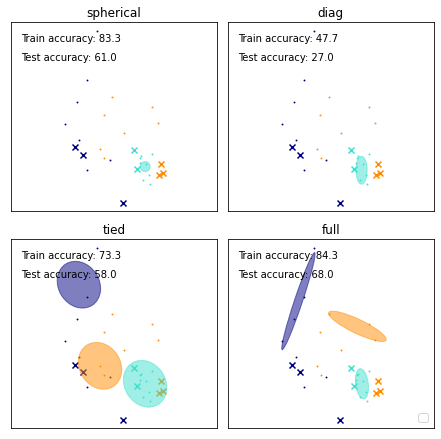

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

#from sklearn import datasets
from sklearn.mixture import GaussianMixture


colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


#iris = datasets.load_iris()



n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X_train[y_train == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

full covariance seems to be the best based on the gmm code I ran



Determine the minimum number of clusters that best represent the dataset using either AIC or BIC. [15 points]


In [ ]:
#from sklearn.mixture import BayesianGaussianMixture
#bgm = BayesianGaussianMixture(n_components=45, n_init=10, random_state=94)
#bgm.fit(X_train)
#np.round(bgm.weights_,2)

In [42]:
# Try GMMs using different numbers of classes.
estimators_classes = {
    n_classes: GaussianMixture(
        n_components=n_classes, covariance_type="full", max_iter=20, random_state=0
    )
    for n_classes in range(41)
}

In [43]:
estimators_classes

{0: GaussianMixture(max_iter=20, n_components=0, random_state=0),
 1: GaussianMixture(max_iter=20, random_state=0),
 2: GaussianMixture(max_iter=20, n_components=2, random_state=0),
 3: GaussianMixture(max_iter=20, n_components=3, random_state=0),
 4: GaussianMixture(max_iter=20, n_components=4, random_state=0),
 5: GaussianMixture(max_iter=20, n_components=5, random_state=0),
 6: GaussianMixture(max_iter=20, n_components=6, random_state=0),
 7: GaussianMixture(max_iter=20, n_components=7, random_state=0),
 8: GaussianMixture(max_iter=20, n_components=8, random_state=0),
 9: GaussianMixture(max_iter=20, n_components=9, random_state=0),
 10: GaussianMixture(max_iter=20, n_components=10, random_state=0),
 11: GaussianMixture(max_iter=20, n_components=11, random_state=0),
 12: GaussianMixture(max_iter=20, n_components=12, random_state=0),
 13: GaussianMixture(max_iter=20, n_components=13, random_state=0),
 14: GaussianMixture(max_iter=20, n_components=14, random_state=0),
 15: GaussianMix

In [44]:
for i in range(1,41):
  estimators_classes[i].fit(X_train)

In [45]:
bic_array = []
for i in range(1, 41):
  j = estimators_classes[i].bic(X_train)
  bic_array.append(j)

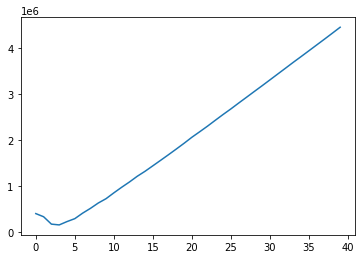

In [46]:
plt.plot(range(40), bic_array)
plt.show()

In [47]:
for i in range(5):
  print(i, bic_array[i])

0 397923.76596259704
1 329588.1964226653
2 168982.24596320023
3 151855.2966140721
4 224494.70103162888


In [49]:
estimators_classes[4].bic(X_train)

151855.2966140721

a minimum of 4 clusters best represent the dataset according to BIC

In [50]:
chosen_estimator = estimators_classes[4]


Output the hard clustering for each instance. [2.5 points]


In [51]:
chosen_estimator.predict(X_train)

array([3, 2, 3, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 1, 1,
       1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1,
       1, 1, 3, 3, 2, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3,
       3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 1, 2, 3, 3, 0, 3, 2, 3,
       3, 3, 0, 0, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 0, 3, 1, 1, 3, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 3, 1, 3, 3])


Output the soft clustering for each instance. [2.5 points]


In [52]:
chosen_estimator.predict_proba(X_train)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])


Use the model to generate some new faces (using the sample() method), and visualize them (use the inverse_transform() method to transform the data back to its original space based on the PCA method used). [15 points]


In [53]:
X_new, y_new = chosen_estimator.sample(5)

In [54]:
X_new

array([[ 86.68511754, -41.30775502,  23.2951141 , ...,   0.71228099,
         -0.53030883,   1.49362537],
       [ -6.91997544, -10.99949776,  13.76755481, ...,   1.27396023,
          1.07057114,  -0.37123203],
       [-13.27445516, -14.75195104,   3.97865687, ...,   1.12156187,
          1.51073054,   1.09918659],
       [-16.28253887, -34.12064034,  -5.21848928, ...,   0.9880917 ,
         -1.48772202,  -0.70176652],
       [-18.15962683,   8.46750756, -10.57674488, ...,  -0.47408216,
         -1.54488749,  -2.99020813]])

In [55]:
X_new.shape

(5, 211)

In [56]:
y_new.shape

(5,)

In [57]:
X_new_inverse_pca = pca.inverse_transform(X_new)

In [58]:
X_new_inverse_pca.shape

(5, 4096)

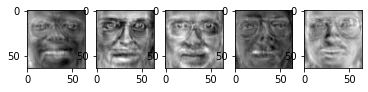

In [59]:
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(X_new_inverse_pca[i].reshape(64,64))
  plt.gray()

8
Modify some images (e.g., rotate, flip, darken). [15 points]

In [60]:
X_train_inverse_pca = pca.inverse_transform(X_train)

In [61]:
n_rotated = 2
X_rotated = np.transpose(X_train_inverse_pca[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
X_rotated = X_rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

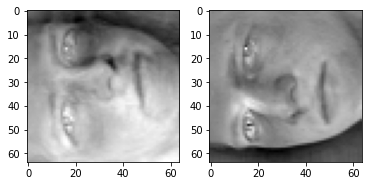

In [62]:
for i in range(2):
  ax = plt.subplot(1, 2, i+1)
  plt.imshow(X_rotated[i].reshape(64,64))
  plt.gray()

In [63]:
y_rotated

array([0., 0.])

In [64]:
n_flipped = 5
flipped = X_train_inverse_pca[3:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

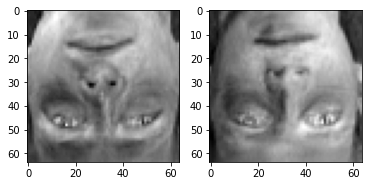

In [65]:
for i in range(2):
  ax = plt.subplot(1, 2, i+1)
  plt.imshow(flipped[i].reshape(64,64))
  plt.gray()

In [66]:
n_darkened = 13
darkened = X_train_inverse_pca[10:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

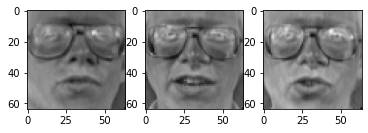

In [67]:
for i in range(3):
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(darkened[i].reshape(64,64))
  plt.gray()


Determine if the model can detect the anomalies produced in (8) by comparing the output of the score_samples() method for normal images and for anomalies). [10 points]

In [68]:
X_altered_faces = np.r_[X_rotated, flipped, darkened]

In [69]:
X_altered_faces_pca = pca.transform(X_altered_faces)

In [70]:
chosen_estimator.score_samples(X_altered_faces_pca)

array([-4.61762412e+08, -4.61898175e+08, -2.54481590e+08, -2.13991635e+08,
       -4.02570696e+07, -4.03252061e+07, -4.03688410e+07])

In [71]:
chosen_estimator.score_samples(X_train)

array([534.10425529, 622.75666103, 534.10424781, 622.75666271,
       534.10425033, 534.10424769, 542.49041007, 622.75666133,
       622.75666178, 622.75666115, 622.75666976, 622.75666246,
       622.75666815, 622.75666801, 622.75666683, 542.49043806,
       542.4904301 , 542.4904128 , 534.10425017, 534.10424916,
       542.49043912, 542.49043599, 542.49041061, 622.75667763,
       622.75667166, 534.10425022, 534.10425161, 542.49041081,
       622.75666095, 622.75666311, 542.49041446, 534.10427174,
       534.10426427, 534.10425285, 534.10424994, 534.10425677,
       534.10425202, 622.75666193, 534.10426204, 534.10425987,
       534.10425716, 534.10425825, 534.10424939, 534.10425369,
       534.10426874, 534.10424573, 534.10424593, 534.10424636,
       622.75666084, 622.75666185, 534.10424653, 534.1042451 ,
       622.75666216, 622.75666183, 622.75667325, 622.75666463,
       622.75666194, 622.75666957, 534.10424578, 622.75666175,
       542.49043644, 542.4904247 , 534.10425021, 534.10

In the analysis report paste the screenshots for each question and write down the explanation if asked.
Show the Demonstration in Lab or Create a video discussing the code and result for each question.